<a href="https://colab.research.google.com/github/Molten-Ice/Deep-Learning/blob/colab/CycleGAN_colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
import os
import time

device = "cuda:0" if torch.cuda.is_available() else "cpu"
# device = "cpu"
print(device)

batch_size = 32

cuda:0


In [2]:
 #Connecting to kaggle API
!pip install kaggle
import json
import zipfile
kaggle_apikey = {"username":"jamesdavey","key":"a8975caa44cfa08d6f2164f2d5977b6e"}

if not os.path.exists('/root/.kaggle'): os.mkdir('/root/.kaggle')
with open('/root/.kaggle/kaggle.json', 'w') as f:
    json.dump(kaggle_apikey, f)
! chmod 600 ~/.kaggle/kaggle.json

# open file at ~/.kaggle/kaggle.json and print it
with open('/root/.kaggle/kaggle.json', 'r') as f:
    print(f.read())

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
{"username": "jamesdavey", "key": "a8975caa44cfa08d6f2164f2d5977b6e"}


In [3]:
# Download simpsons dataset from kaggle
! kaggle datasets download -d kostastokis/simpsons-faces
#unzip file simpsons-faces.zip
with zipfile.ZipFile("simpsons-faces.zip","r") as zip_ref:
    zip_ref.extractall("simpsons-data")

100% 441M/442M [00:13<00:00, 40.6MB/s]
100% 442M/442M [00:13<00:00, 34.3MB/s]


In [4]:
# Download faces dataset from kaggle
! kaggle datasets download -d atulanandjha/lfwpeople
with zipfile.ZipFile("lfwpeople.zip","r") as zip_ref:
    zip_ref.extractall()

import tarfile
tar = tarfile.open("lfw-funneled.tgz")
tar.extractall()
tar.close()

100% 232M/232M [00:06<00:00, 33.5MB/s]
100% 232M/232M [00:06<00:00, 36.5MB/s]


In [5]:
names = sorted(os.listdir('lfw_funneled'))[:-12]
print("number of people:", len(names), names[:5])

faces_file_paths = []
counter= 0 
for name in names:
    images_in_folder = os.listdir('lfw_funneled/'+name)
    faces_file_paths.extend([name+"/"+x for x in images_in_folder[:2]])
    counter += 1
    if counter > 10000: break # Deleted this line to get all the images

print("number of face images:", len(faces_file_paths), faces_file_paths[:5])

simpson_file_paths = sorted(os.listdir('simpsons-data/cropped'))
print("number of simpsons images:", len(simpson_file_paths), simpson_file_paths[:5])

number of people: 5748 ['AJ_Cook', 'AJ_Lamas', 'Aaron_Eckhart', 'Aaron_Guiel', 'Aaron_Patterson']
number of face images: 7428 ['AJ_Cook/AJ_Cook_0001.jpg', 'AJ_Lamas/AJ_Lamas_0001.jpg', 'Aaron_Eckhart/Aaron_Eckhart_0001.jpg', 'Aaron_Guiel/Aaron_Guiel_0001.jpg', 'Aaron_Patterson/Aaron_Patterson_0001.jpg']
number of simpsons images: 9877 ['1.png', '10.png', '100.png', '1000.png', '1001.png']


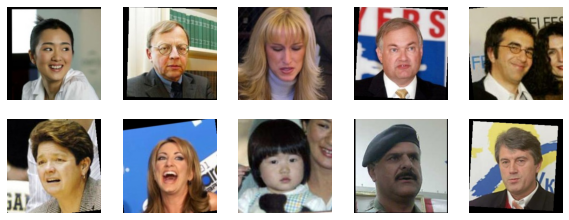

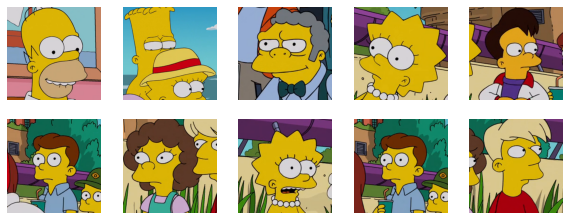

In [8]:
# display 10 faces images
random_indices = np.random.randint(0, len(faces_file_paths), 10)
plt.figure(figsize=(10,10))
for i in range(10):
    plt.subplot(5,5,i+1)
    img = plt.imread('lfw_funneled/'+faces_file_paths[random_indices[i]])
    plt.imshow(img)
    plt.axis('off')
plt.show()

# display 10 simpsons images
plt.figure(figsize=(10,10))
for i in range(10):
    plt.subplot(5,5,i+1)
    img = plt.imread('simpsons-data/cropped/'+simpson_file_paths[i])
    plt.imshow(img)
    plt.axis('off')
plt.show()


In [9]:
#Create traindataloader from simpsons dataset
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, root_dir, file_paths, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.file_paths = file_paths
        self.len = len(self.file_paths)
        
    def __len__(self):
        return self.len
    
    def __getitem__(self, idx):
        img = plt.imread(self.root_dir + self.file_paths[idx])
        if self.transform:
            img = self.transform(img)
        return img

# faces_mean = 0.0
# faces_std = 0.0
# for img in faces_dataset:
#     faces_mean+=img.mean([1,2])
#     faces_std+=img.std([1,2])
# faces_mean = faces_mean/len(faces_dataset)
# faces_std = faces_std/len(faces_dataset)
# print(faces_mean, faces_std)

# simpsons_mean = 0.0
# simpsons_std = 0.0
# for img in simpsons_dataset:
#     simpsons_mean+=img.mean([1,2])
#     simpsons_std+=img.std([1,2])
    
# simpsons_mean = simpsons_mean/len(simpsons_dataset)
# simpsons_std = simpsons_std/len(simpsons_dataset)
# print(simpsons_mean, simpsons_std)
    
faces_mean, faces_std = (0.4339, 0.3770, 0.3373), (0.2682, 0.2454, 0.2354)
simp_mean, simp_std = (0.6018, 0.5183, 0.2937), (0.2526, 0.2123, 0.2660)

faces_transforms = transforms.Compose([transforms.ToTensor(), transforms.Resize((256,256)),
                                       transforms.Normalize(faces_mean, faces_std)])
simp_transforms = transforms.Compose([transforms.ToTensor(), transforms.Resize((256,256)),
                                       transforms.Normalize(simp_mean, simp_std)])

print("total simpsons images:", len(simpson_file_paths), "| total faces images:", len(faces_file_paths))
max_length = min(len(simpson_file_paths), len(faces_file_paths))
faces_dataset = CustomDataset('lfw_funneled/', faces_file_paths[:max_length], transform=faces_transforms)
simpsons_dataset = CustomDataset('simpsons-data/cropped/', simpson_file_paths[:max_length], transform=simp_transforms)

# create dataloaders
faces_dataloader = torch.utils.data.DataLoader(faces_dataset, batch_size=batch_size, shuffle=True)
simpsons_dataloader = torch.utils.data.DataLoader(simpsons_dataset, batch_size=batch_size, shuffle=True)
print("simpsons_dataloader:", len(simpsons_dataloader), "of batch size", batch_size)
print("faces_dataloader:", len(faces_dataloader), "of batch size", batch_size)


total simpsons images: 9877 | total faces images: 7428
simpsons_dataloader: 233 of batch size 32
faces_dataloader: 233 of batch size 32


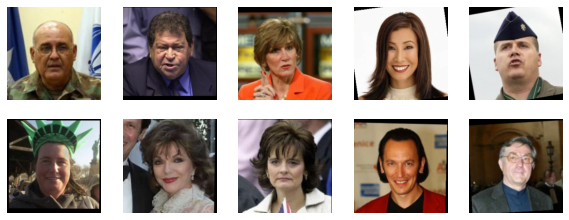

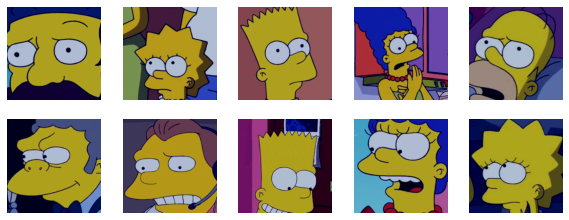

In [10]:
inv_transformation_face = transforms.Compose([ transforms.Normalize(mean = [ 0., 0., 0. ],
                                                     std = ([1/s for s in faces_std])),
                                                transforms.Normalize(mean = [ -m for m in faces_mean ],
                                                                    std = [ 1., 1., 1. ])])
inv_transformation_simp = transforms.Compose([ transforms.Normalize(mean = [ 0., 0., 0. ],
                                                         std = ([1/s for s in simp_std])),     
                                                  transforms.Normalize(mean = [ -m for m in simp_mean ],
                                                                        std = [ 1., 1., 1. ])])
                                                                        
# display 10 images
plt.figure(figsize=(10,10))
for i, batch in enumerate(faces_dataloader):
    for j in range(batch_size):
        if i*batch_size+j >=10: break
        plt.subplot(5,5,i*batch_size+j+1)
        image = inv_transformation_face(batch[j])
        plt.imshow(image.clip(0,1).permute(1,2,0).numpy())
        plt.axis('off')
    if i*batch_size+j >=10: break
plt.show()

# display 10 images
plt.figure(figsize=(10,10))
for i, batch in enumerate(simpsons_dataloader):
    for j in range(batch_size):
        if i*batch_size+j >=10: break
        plt.subplot(5,5,i*batch_size+j+1)
        image = inv_transformation_face(batch[j])
        plt.imshow(image.clip(0,1).permute(1,2,0).numpy())
        plt.axis('off')
    if i*batch_size+j >=10: break
plt.show()

In [11]:
###############################################################################
# Models
###############################################################################
class DoubleConv(nn.Module):
  def __init__(self, input_channels: int, output_channels: int):
    """Initialize the DownSampleBlock class.
      
    Parameters:
      input_size (int) -- input size to block
      input_channels (int) -- #channels into first layer in block
      output_channels (int) -- #channels each layer produces
    """
    super().__init__()
    conv1 = nn.Conv2d(in_channels=input_channels, out_channels=output_channels, kernel_size=3, stride=1, padding=1)
    conv2 = nn.Conv2d(in_channels=output_channels, out_channels=output_channels, kernel_size=3, stride=1, padding=1)

    nn.init.normal_(conv1.weight, mean=0.0, std= (2/(9*input_channels))**(1/2)) #sqrt(2/N)
    nn.init.normal_(conv2.weight, mean=0.0, std= (2/(9*output_channels))**(1/2)) 
    
    self.conv = nn.Sequential(conv1, nn.BatchNorm2d(output_channels), nn.ReLU(),
                              conv2, nn.BatchNorm2d(output_channels), nn.ReLU())
    
  def forward(self, x: torch.Tensor) -> torch.Tensor:
    return self.conv(x)

class DownSampleBlock(nn.Module):
  """
  DownSampling block in UNET

  MaxPool, DoubleCov
  MaxPool, Conv, BatchNorm, ReLU, Conv, BatchNorm, ReLU
  """
  def __init__(self, input_channels: int, output_channels: int):
    """Initialize the DownSampleBlock class.

    Parameters:
      input_size (int) -- input size to block
      input_channels (int) -- #channels into first layer in block
      output_channels (int) -- #channels each layer produces
    """
    super().__init__()
    self.max_pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
    self.conv = DoubleConv(input_channels, output_channels)

  def forward(self, x: torch.Tensor) -> torch.Tensor:
    return self.conv(self.max_pool(x))

class UpSampleBlock(nn.Module):
  """
  UpSampling block in UNET

  Upsample, Conv, Concat, Conv, ReLU, Conv, ReLU
  """
  def __init__(self, input_channels: int, output_channels: int):
    """Initialize the DownSampleBlock class.
    
    Parameters:
      input_size (int) -- input size to block
      input_channels (int) -- #channels into first layer in block
      output_channels (int) -- #channels each layer produces
    """
    super().__init__()
    self.up_sample = nn.ConvTranspose2d(input_channels, output_channels, kernel_size=2, stride=2)
    self.conv = DoubleConv(input_channels, output_channels)

  def forward(self, x: torch.Tensor, res: torch.Tensor) -> torch.Tensor:
    """Forward pass for DownSampleBlock.

     Parameters:
      x (torch.Tensor) -- input tensor to block
      res (torch.Tensor) -- residual connection feeding into block
    
    Return x
    x will be used as the input to the next upsizing block (or final layer)
    """
    x = self.up_sample(x)
    # size_diff1 = (res.shape[2]-x.shape[2])//2
    # size_diff2 = (res.shape[2]-x.shape[2]) - size_diff1
    # x = torch.concat((x, res[:, :, size_diff1:-size_diff2, size_diff1:-size_diff2]), dim = 1)
    x = torch.cat((x, res), dim = 1)
    x = self.conv(x)
    return x

class UNET(nn.Module):
  def __init__(self, channels_in = 3):
    """Initialize the DownSampleBlock class.
    
    Parameters:
      channels_in (int) -- input images channel size
    """
    super().__init__()
    self.first_conv = DoubleConv(channels_in, 64)
    self.downsample_blocks = nn.ModuleList([DownSampleBlock(c, 2*c) for c in [64, 128, 256, 512]])
    self.upsample_blocks = nn.ModuleList([UpSampleBlock(2*c, c) for c in [512, 256, 128, 64]])
    self.final_layer = nn.Conv2d(in_channels=64, out_channels=channels_in, kernel_size=1, stride=1, padding=0)
    self.tanh = nn.Tanh()
  
  def forward(self, x: torch.Tensor) -> torch.Tensor:
    """Forward pass for DownSampleBlock.

     Parameters:
      x (torch.Tensor) --input tensor to block
      targets (torch.Tensor) --target output of model

    Returns (logits, loss)

    logits (torch.Tensor) --model's raw output
    loss (torch.float32) --2d CrossEntropyLoss result
    """
    x = self.first_conv(x)
    residuals = []
    for downsample in self.downsample_blocks:
      residuals.append(x)
      x = downsample(x)
    for i, upsample in enumerate(self.upsample_blocks):
      x = upsample(x, residuals[-(i+1)])
    x = self.final_layer(x)
    return self.tanh(x)
  
class Discriminator(nn.Module):
    """Discriminator network with PatchGAN."""
    def __init__(self, 
                input_channels: int = 3):
        super().__init__()

        self.conv1 = nn.Conv2d(input_channels, 64, 4, 2, 1)
        self.conv2 = nn.Conv2d(64, 128, 4, 2, 1)
        self.bn2 = nn.BatchNorm2d(128)
        self.conv3 = nn.Conv2d(128, 256, 4, 2, 1)
        self.bn3 = nn.BatchNorm2d(256)
        self.conv4 = nn.Conv2d(256, 512, 4, 2, 1)
        self.bn4 = nn.BatchNorm2d(512)
        self.conv5 = nn.Conv2d(512, 1, 4, 1, 0)
        self.leaky_relu = nn.LeakyReLU(0.2)
        self.sigmoid = nn.Sigmoid()
        self.flatten = nn.Flatten()
        
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.leaky_relu(self.conv1(x))
        x = self.leaky_relu(self.bn2(self.conv2(x)))
        x = self.leaky_relu(self.bn3(self.conv3(x)))
        x = self.leaky_relu(self.bn4(self.conv4(x)))
        x = self.sigmoid(self.conv5(x))
        x = self.flatten(x)
        return torch.mean(x, dim=1)

# input = torch.randn(5, 3, 256, 256)
# D = Discriminator()
# print(D(input).shape)

# x = torch.randn(5, 3, 256, 256)
# model = UNET()
# print(model(x)[0].shape)

In [22]:
G = UNET().to(device)
F = UNET().to(device)

D_y = Discriminator().to(device)
D_x = Discriminator().to(device)

faces = next(iter(faces_dataloader)).to(device)
simpsons = next(iter(simpsons_dataloader)).to(device)

print(faces.shape, simpsons.shape)
print(G(faces).shape, F(simpsons).shape)
print(D_y(faces).shape, D_y(G(faces)).shape)
print(D_x(simpsons).shape, D_x(F(simpsons)).shape)

torch.Size([32, 3, 256, 256]) torch.Size([32, 3, 256, 256])
torch.Size([32, 3, 256, 256]) torch.Size([32, 3, 256, 256])
torch.Size([32]) torch.Size([32])
torch.Size([32]) torch.Size([32])


Generating fake simpsons images (from faces)...


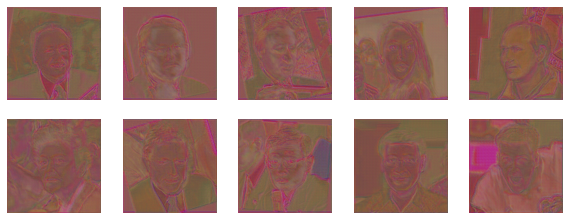

Generating fake faces images (from simpsons)...


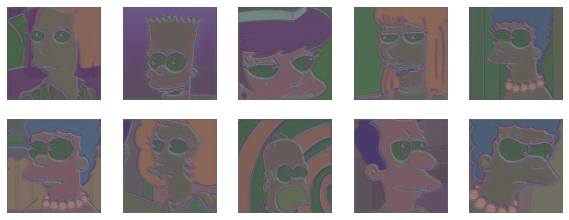

In [23]:
def display_generated_images(G, F):
    print("Generating fake simpsons images (from faces)...")
    # display 10 images
    plt.figure(figsize=(10,10))
    for i, batch in enumerate(faces_dataloader):
        pred_images = G(batch.to(device)).cpu().detach()
        for j in range(batch_size):
            if i*batch_size+j >=10: break 
            plt.subplot(5,5,i*batch_size+j+1)
            image = inv_transformation_face(pred_images[j])
            plt.imshow(image.clip(0,1).permute(1,2,0).numpy())
            plt.axis('off')
        if i*batch_size+j >=10: break 
    plt.show()

    print("Generating fake faces images (from simpsons)...")
    # display 10 images
    plt.figure(figsize=(10,10))
    for i, batch in enumerate(simpsons_dataloader):
        pred_images = F(batch.to(device)).cpu().detach()
        for j in range(batch_size):
            if i*batch_size+j >=10: break 
            plt.subplot(5,5,i*batch_size+j+1)
            image = inv_transformation_face(pred_images[j])
            plt.imshow(image.clip(0,1).permute(1,2,0).numpy())
            plt.axis('off')
        if i*batch_size+j >=10: break 
    plt.show()

def zero_all_grads():
    G.zero_grad()
    F.zero_grad()
    D_y.zero_grad()
    D_x.zero_grad()

display_generated_images(G, F)

Epoch [0/50] Batch 232/233             Loss D_y: 0.3541, Loss D_x: 0.5306 loss G: 1.0360, loss F: 0.6592 | lr:[2.000000000000001e-09] | epoch time 308.6190s, total elapsed: 308.6194s 
Generating fake simpsons images (from faces)...


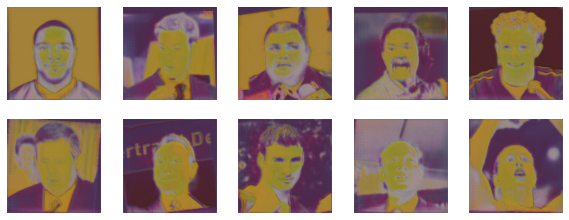

Generating fake faces images (from simpsons)...


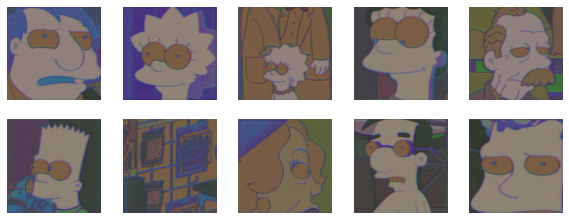

Epoch [1/50] Batch 232/233             Loss D_y: 0.2814, Loss D_x: 0.5806 loss G: 1.0502, loss F: 0.6626 | lr:[2.000000000000001e-09] | epoch time 308.1298s, total elapsed: 618.1300s 
Generating fake simpsons images (from faces)...


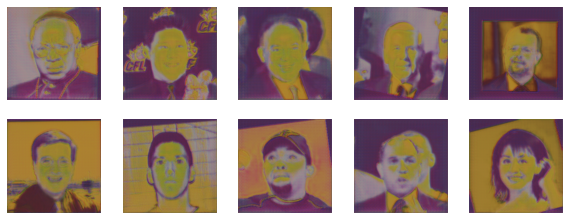

Generating fake faces images (from simpsons)...


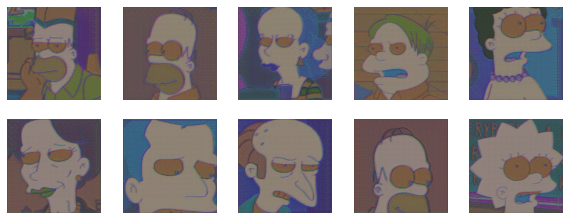

KeyboardInterrupt: ignored

In [24]:
################## Hyperparameters ##################
epochs = 50
milestones = [25, 30, 35, 40, 45]
learning_rate = 0.0002

l1_loss_fn = nn.L1Loss()
l2_loss_fn = nn.MSELoss()

################## Training loop ##################
G_optimizer = torch.optim.Adam(G.parameters(), lr=learning_rate, betas=(0.5, 0.999))
F_optimizer = torch.optim.Adam(F.parameters(), lr=learning_rate, betas=(0.5, 0.999))
D_y_optimizer = torch.optim.Adam(D_y.parameters(), lr=learning_rate, betas=(0.5, 0.999))
D_x_optimizer = torch.optim.Adam(D_x.parameters(), lr=learning_rate, betas=(0.5, 0.999))

G_scheduler = torch.optim.lr_scheduler.MultiStepLR(G_optimizer, milestones=milestones, gamma=0.1)
F_scheduler = torch.optim.lr_scheduler.MultiStepLR(F_optimizer, milestones=milestones, gamma=0.1)
D_y_scheduler = torch.optim.lr_scheduler.MultiStepLR(D_y_optimizer, milestones=milestones, gamma=0.1)
D_x_scheduler = torch.optim.lr_scheduler.MultiStepLR(D_x_optimizer, milestones=milestones, gamma=0.1)


t_interval = time.time()
t_start = time.time()
for epoch in range(epochs):
    t_epoch = time.time()
    for batch_idx, (faces, simpsons) in enumerate(zip(faces_dataloader, simpsons_dataloader)):
        B, C, H, W = faces.shape
        faces, simpsons = faces.to(device), simpsons.to(device)
        real_labels = torch.ones(B).to(device)
        fake_labels = torch.zeros(B).to(device)

        ########## Train Discriminators Y ##########
        #Minimizing adversarial loss
        
        ## D_y ##
        #Minimizing D_y for (D_y(x) - 1)^2 + (D_y(G(x)) - 0)^2
        simpsons_pred_real = D_y(simpsons)
        simpsons_pred_fake = D_y(G(faces))
        D_y_loss = l2_loss_fn(simpsons_pred_real, real_labels) + l2_loss_fn(simpsons_pred_fake, fake_labels)
        zero_all_grads()
        D_y_loss.backward()
        D_y_optimizer.step()

        ## D_x ##
        #Minimizing D_y for (D_x(x) - 1)^2 + (D_x(G(x)) - 0)^2
        faces_pred_real = D_y(faces)
        faces_pred_fake = D_y(G(simpsons))
        D_x_loss = l2_loss_fn(faces_pred_real, real_labels) + l2_loss_fn(faces_pred_fake, fake_labels)
        zero_all_grads()
        D_x_loss.backward()
        D_x_optimizer.step()
        
        ########## Train Generators ############
       
        ## G ##
        #Minimizing G for (D_y(G(x)) - 1)^2
        generated_images_g = G(faces) # would normally use random noise here instead of faces
        pred_labels_g = D_y(generated_images_g)
        generator_loss_g = l2_loss_fn(pred_labels_g, real_labels)

        #Cycle consistency loss
        generated_images_g_f = F(generated_images_g)
        cycle_consistency_loss_g = l1_loss_fn(generated_images_g_f, faces)
        
        loss_g = generator_loss_g + cycle_consistency_loss_g
        zero_all_grads()
        loss_g.backward()
        G_optimizer.step()

        ## F ##
        #Minimizing F for (D_x(F(x)) - 1)^2
        generated_images_f = F(simpsons)
        pred_labels_f = D_x(generated_images_f)
        generator_loss_f = l2_loss_fn(pred_labels_f, real_labels)

        #Cycle consistency loss
        generated_images_f_g = G(generated_images_f)
        cycle_consistency_loss_f = l1_loss_fn(generated_images_f_g, simpsons)

        loss_f = generator_loss_f + cycle_consistency_loss_f
        zero_all_grads()
        loss_f.backward()
        F_optimizer.step()


        G_scheduler.step()
        F_scheduler.step()
        D_y_scheduler.step()
        D_x_scheduler.step()

        # if batch_idx % 200 == 0:
        #     print(f"Epoch [{epoch}/{epochs}] Batch {batch_idx}/{len(faces_dataloader)} \
        #           Loss D_y: {D_y_loss:.4f}, Loss D_x: {D_x_loss:.4f} loss G: {loss_g:.4f}, loss F: {loss_f:.4f} | lr:{G_scheduler.get_last_lr()} | interval time {time.time()-t_interval:.4f}s")
        #     t_interval = time.time()
        #     display_generated_images(G, F)
    # print(f"Epoch [{epoch}/{epochs}] time taken: {time.time()-t_epoch:.4f}s, total elapsed: {time.time()-t_start:.4f}s")

    print(f"Epoch [{epoch}/{epochs}] Batch {batch_idx}/{len(faces_dataloader)} \
            Loss D_y: {D_y_loss:.4f}, Loss D_x: {D_x_loss:.4f} loss G: {loss_g:.4f}, loss F: {loss_f:.4f} | lr:{G_scheduler.get_last_lr()} | epoch time {time.time()-t_epoch:.4f}s, total elapsed: {time.time()-t_start:.4f}s ")
    display_generated_images(G, F)
    

Generating fake simpsons images (from faces)...


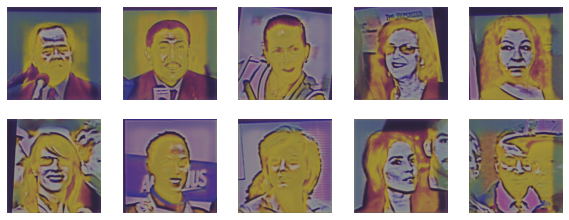

Generating fake faces images (from simpsons)...


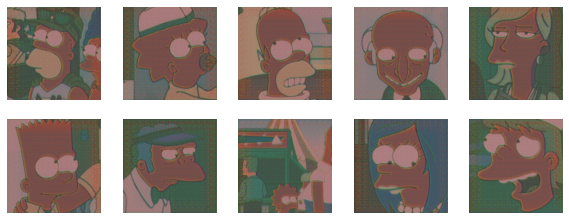

In [39]:
display_generated_images(G, F)